### How does PDE dynamics change with synthetic timesteps?

In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

# with h5py.File(f'data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import hydra
from omegaconf import DictConfig, OmegaConf
from generate_data import evolve, generate_ic
from tqdm import tqdm

class Traj_dataset:
    traj_train = None
    traj_valid = None
    traj_test = None

def mean_std_normalize():
    assert Traj_dataset.traj_train is not None
    mean = Traj_dataset.traj_train[:32].mean()
    std = Traj_dataset.traj_train[:32].std()
    print(f'Mean: {mean}, Std: {std}')
    Traj_dataset.mean = 0.0
    Traj_dataset.std = 1.0

# def mean_std_normalize():
#     assert Traj_dataset.traj_train is not None
#     mean = Traj_dataset.traj_train[:32].mean()
#     std = Traj_dataset.traj_train[:32].std()
#     print(f'Mean: {mean}, Std: {std}')
#     Traj_dataset.mean = mean
#     Traj_dataset.std = std

def max_min_normalize():
    assert Traj_dataset.traj_train is not None
    max_val = Traj_dataset.traj_train[:32].max()
    min_val = Traj_dataset.traj_train[:32].min()
    mean = (max_val + min_val) / 2
    std = (max_val - min_val) / 2
    print(f'Max: {max_val}, Min: {min_val}')
    Traj_dataset.mean = mean
    Traj_dataset.std = std


hydra.initialize(config_path="cfg_long_hal", version_base=None)
cfg = hydra.compose(config_name="config", overrides=["task=Heat", "nt=131"])


print('Loading training data...')
with h5py.File(cfg.dataset.train_path, 'r') as f:
    Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:cfg.datasize, :131], dtype=torch.float32)
print('Loading test data...')
with h5py.File(cfg.dataset.test_path, 'r') as f:
    Traj_dataset.traj_test = torch.tensor(f['test']['pde_140-256'][:cfg.testsize, :131], dtype=torch.float32)

if cfg.equation == 'Heat' or cfg.equation == 'KS':
    max_min_normalize()
else:
    mean_std_normalize()

Loading training data...
Loading test data...
Max: 2.4043900966644287, Min: -2.45027232170105


Text(0.5, 1.0, 'Example trajectory of Heat')

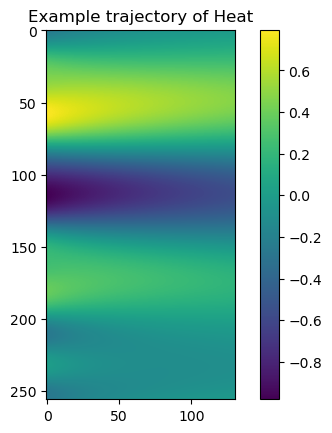

In [3]:
plt.figure()
plt.imshow(Traj_dataset.traj_train[0].cpu().numpy().T)
plt.colorbar()
plt.title(f'Example trajectory of {cfg.equation}')

In [4]:
import h5py
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm
import random

import argparse
import time

from eval_utils import compute_metrics
from utils import set_seed, flatten_configdict, trajectory_model, direct_model, split_model, normalized_model

unrolling = cfg.train.unrolling
nt = cfg.nt
ensemble_size = 5
num_acquire = cfg.num_acquire
device = cfg.device
epochs = cfg.train.epochs
lr = cfg.train.lr
batch_size = cfg.train.batch_size
initial_datasize = cfg.initial_datasize

def train(Y, train_nts, **kwargs):
    model = FNO(n_modes=tuple(cfg.model.n_modes), hidden_channels=64,
                in_channels=1, out_channels=1)
    model = model.to(device)
    model = normalized_model(model, Traj_dataset.mean, Traj_dataset.std, Traj_dataset.mean, Traj_dataset.std)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    inputs = []
    outputs = []
    for b in range(Y.shape[0]):
        for t in range(train_nts[b].item()-1):
            inputs.append(Y[b,t])
            outputs.append(Y[b, t+1])
    inputs = torch.stack(inputs, dim=0).unsqueeze(1)
    outputs = torch.stack(outputs, dim=0).unsqueeze(1)

    dataset = torch.utils.data.TensorDataset(inputs, outputs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in tqdm(range(epochs)):
        model.train()
        # max_unrolling = epoch if epoch <= unrolling else unrolling
        # unrolling_list = [r for r in range(max_unrolling + 1)]

        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            
            pred = model(x)
            loss = criterion(pred, y)

            # loss = torch.sqrt(loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        # wandb.log({f'train/loss_{acquire_step}': total_loss})
    return model

datasize=16
timestep = (Traj_dataset.traj_train.shape[1] - 1) // (nt - 1) # 10
Y = Traj_dataset.traj_train[:,0::timestep]
train_nts = torch.zeros(Y.shape[0], device=device).int()
train_nts[:datasize] = nt
# model = train(Y, train_nts)
ensemble = [train(Y, train_nts) for _ in range(ensemble_size)]

100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


/tmp/ipykernel_103731/2860638801.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


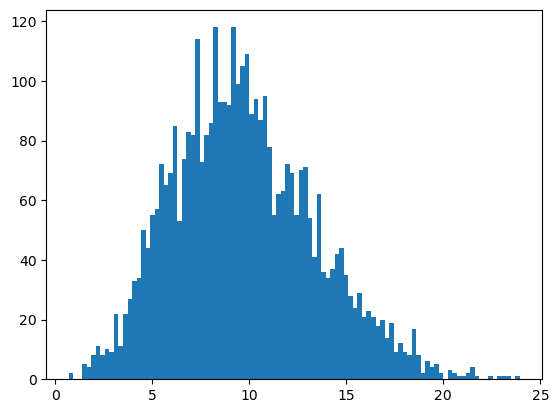

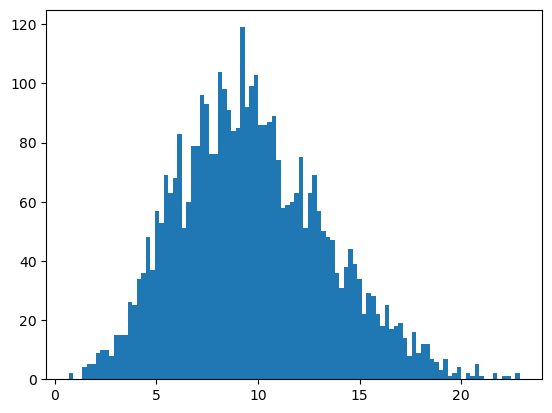

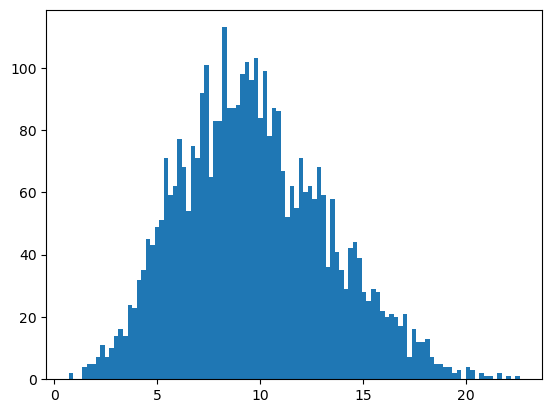

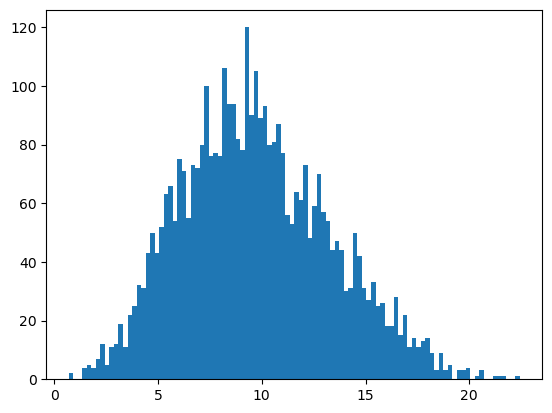

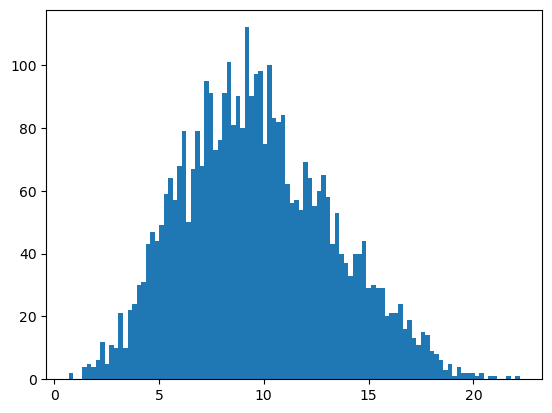

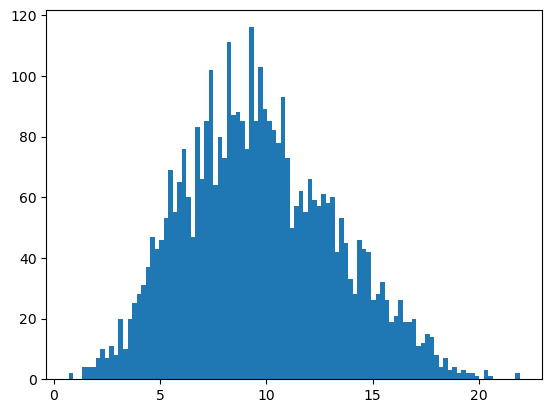

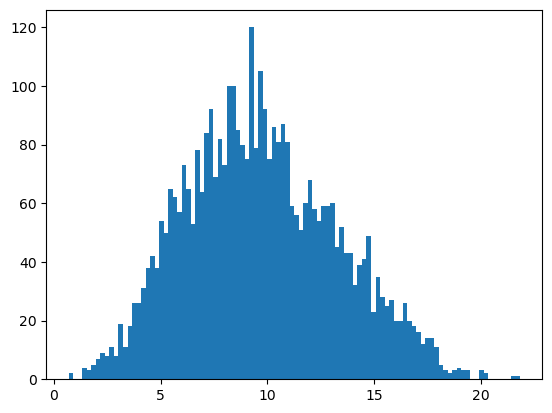

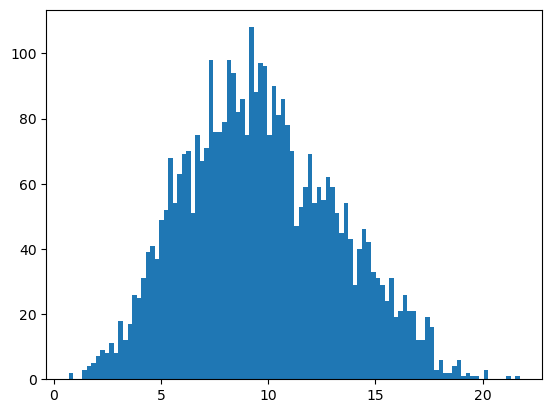

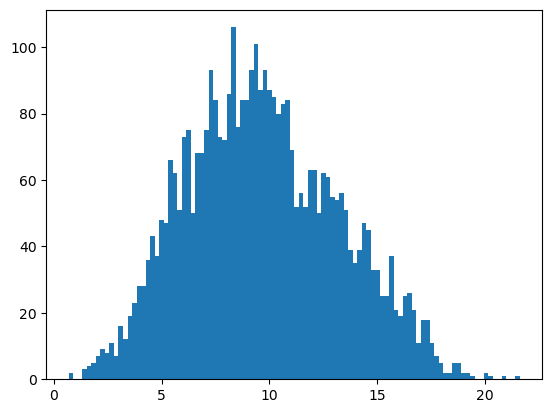

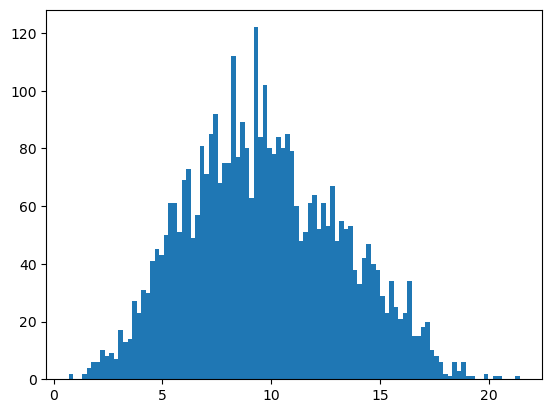

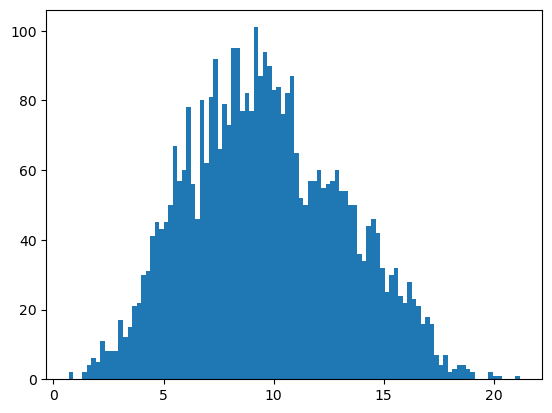

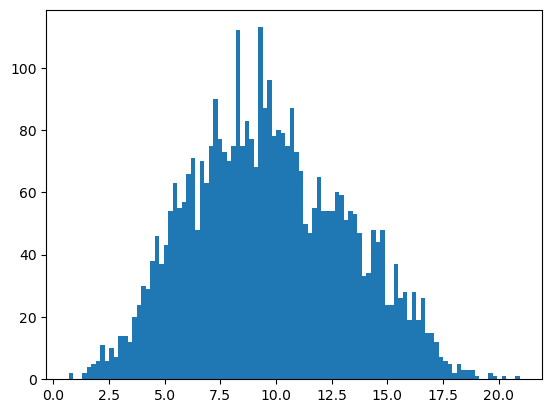

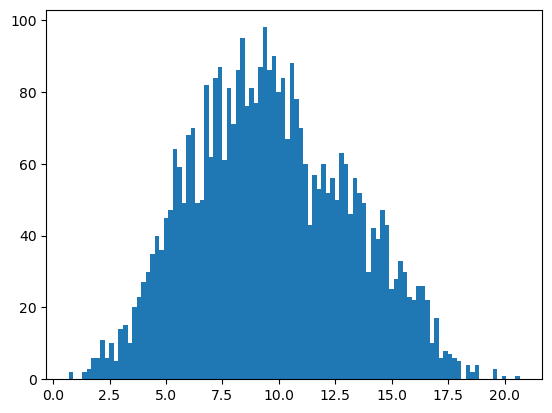

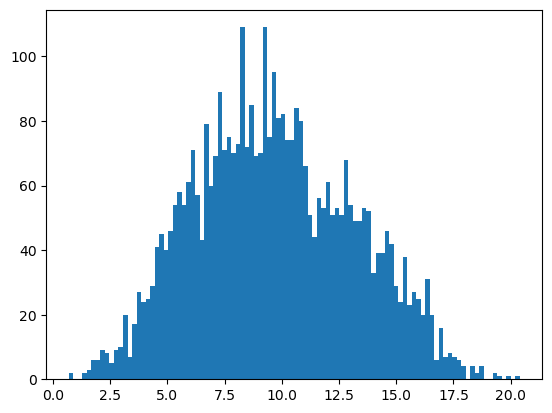

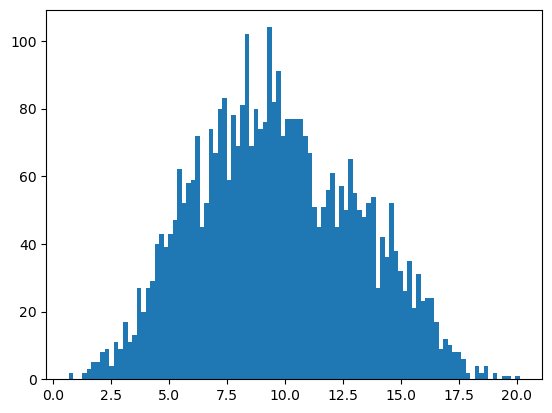

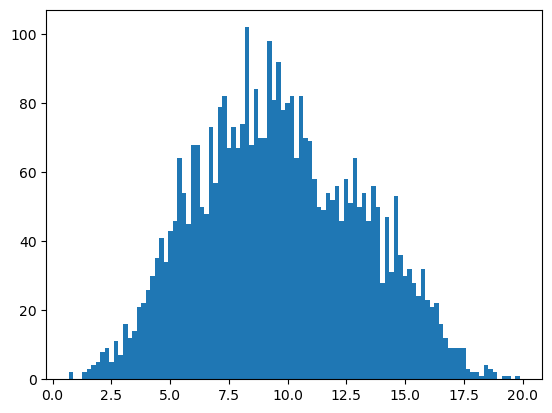

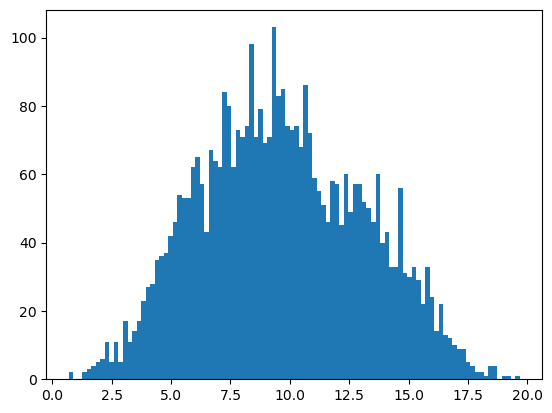

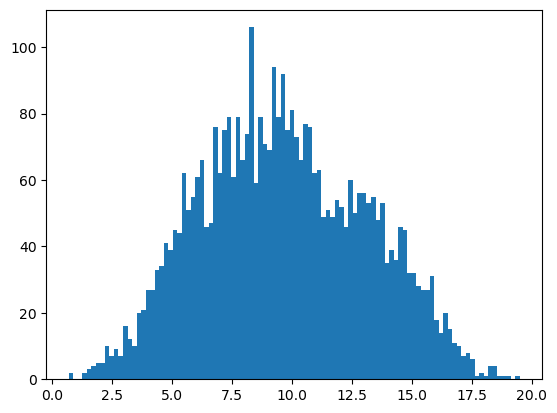

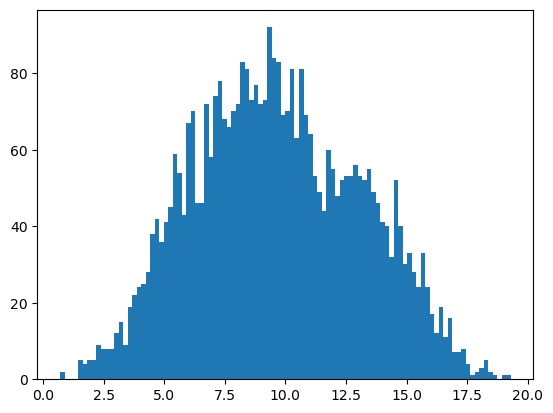

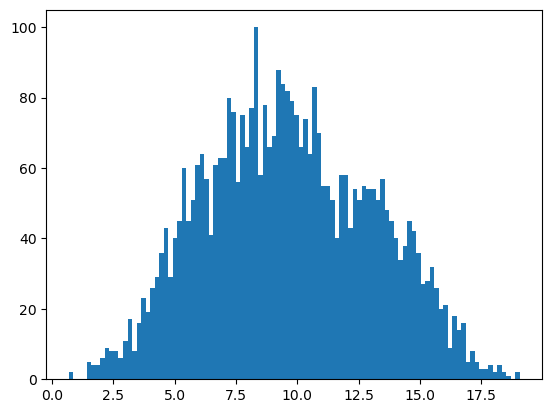

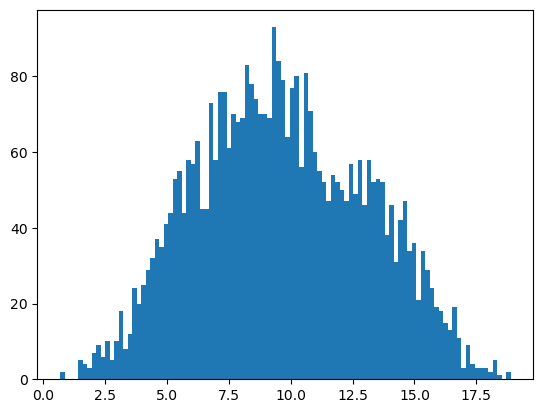

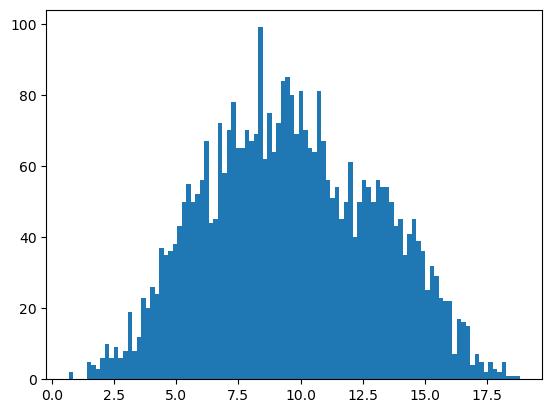

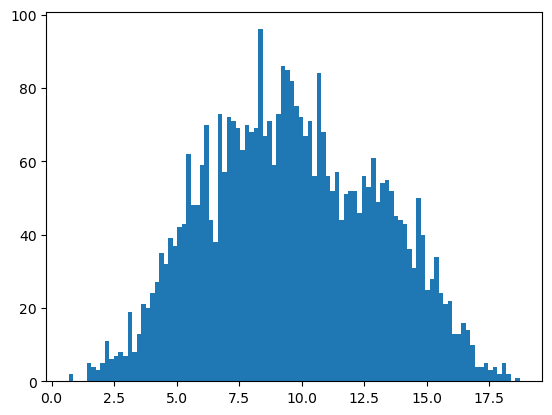

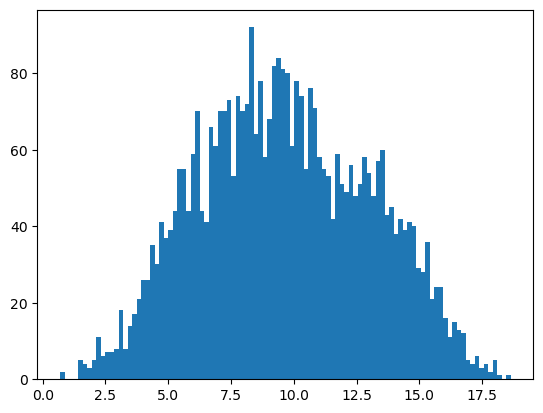

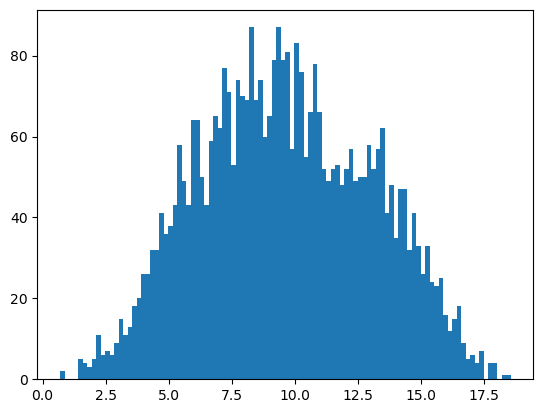

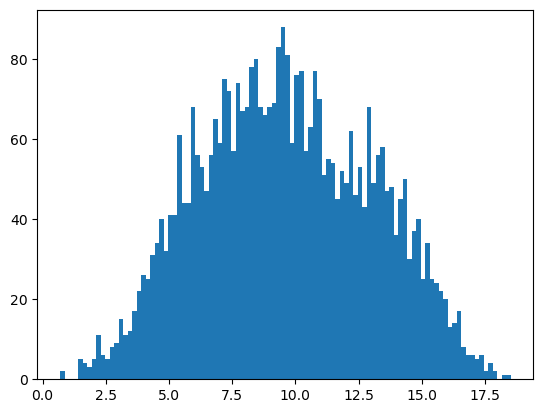

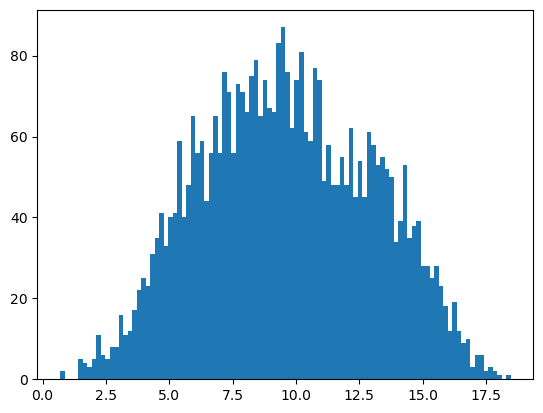

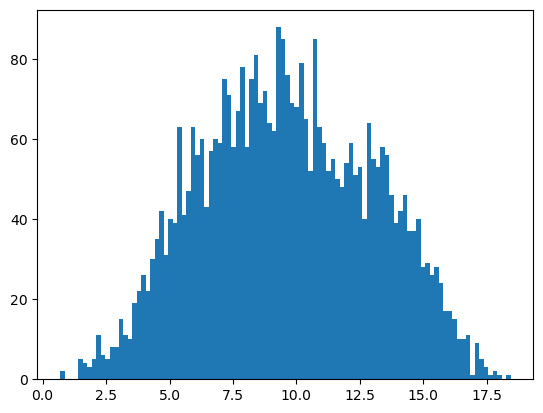

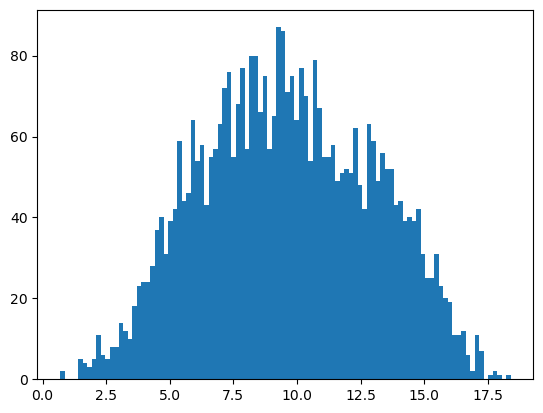

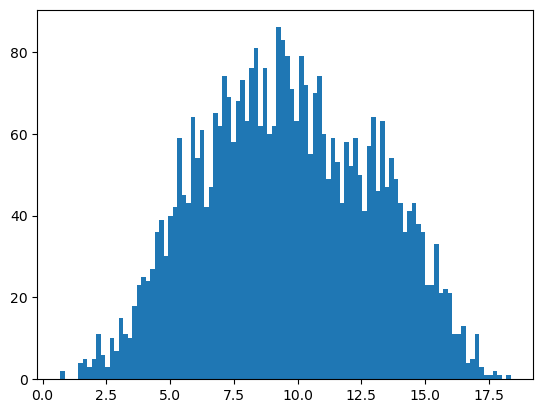

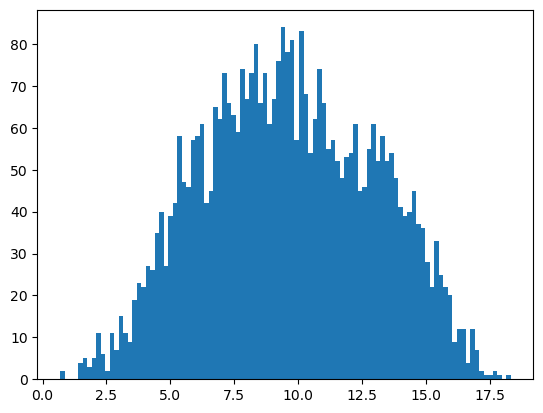

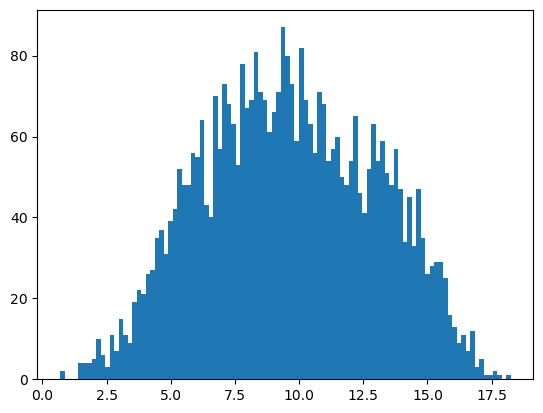

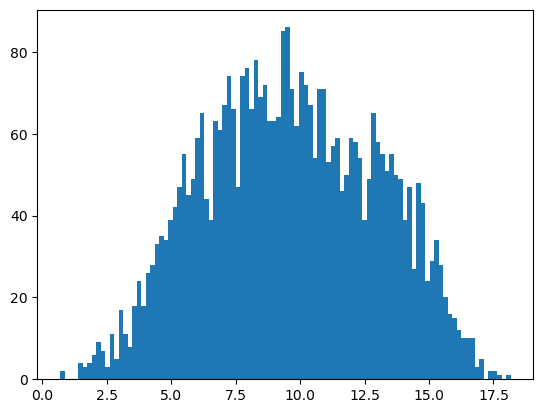

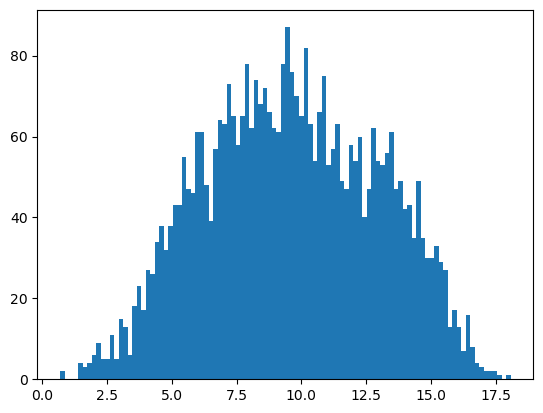

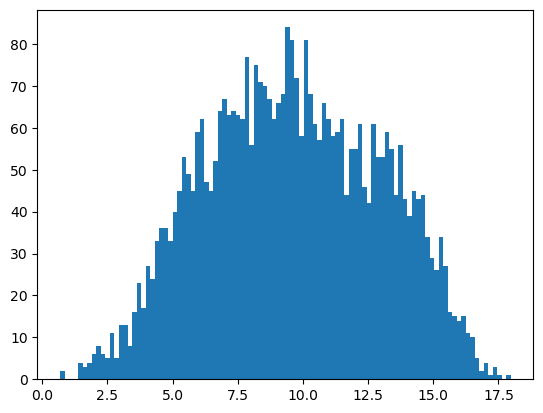

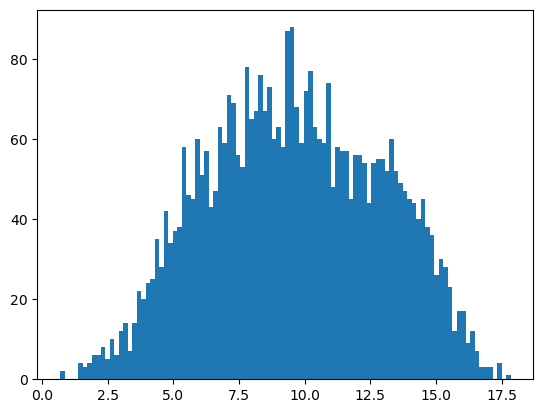

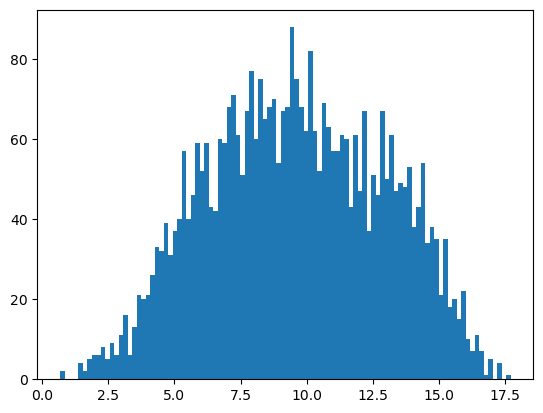

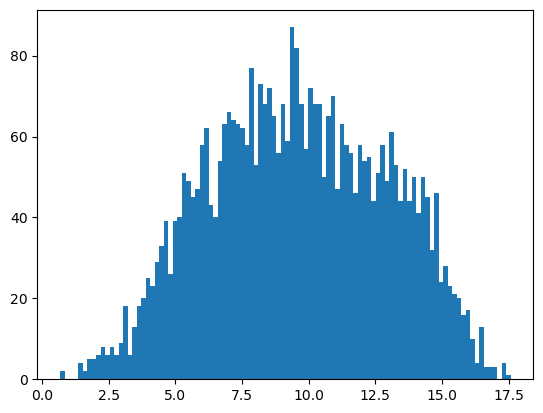

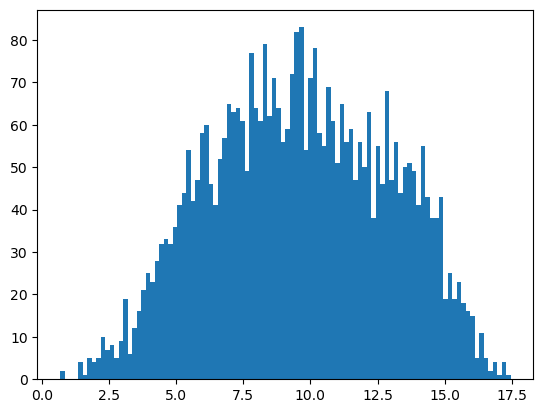

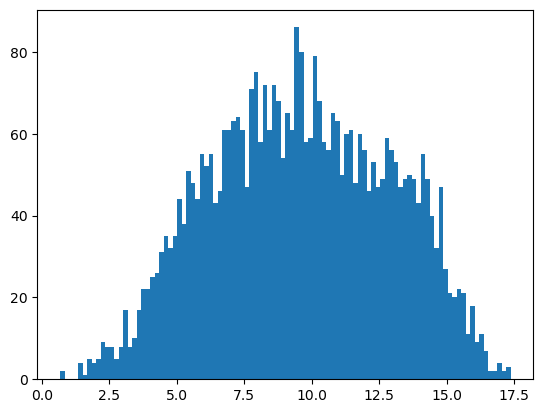

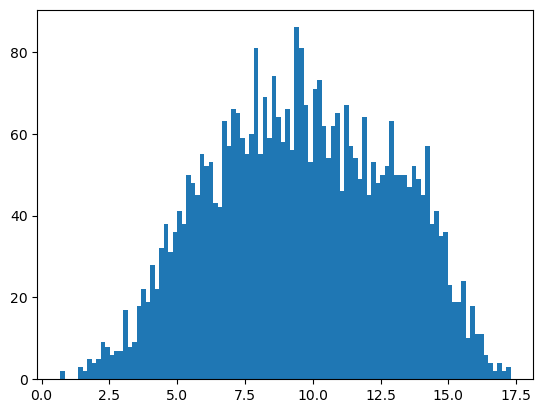

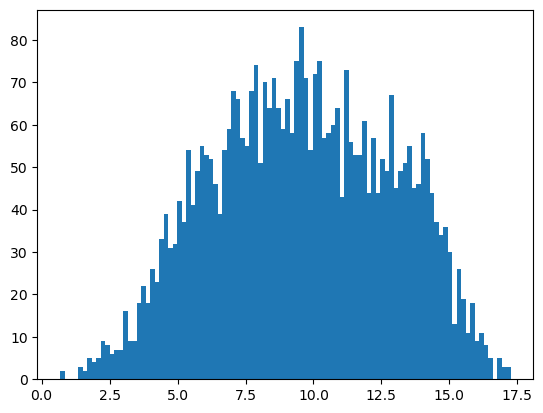

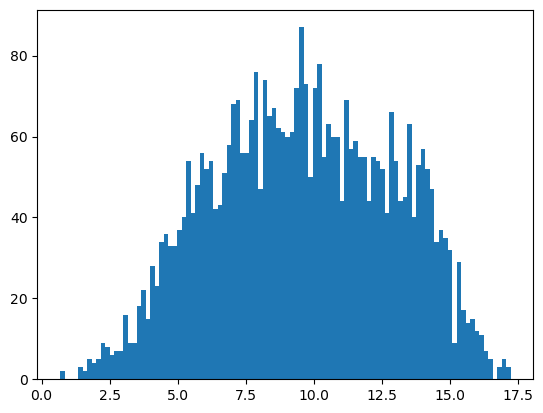

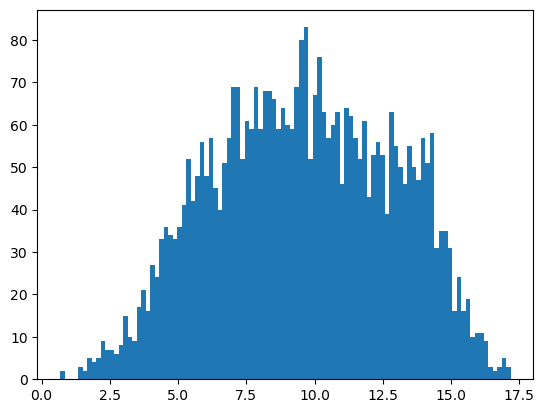

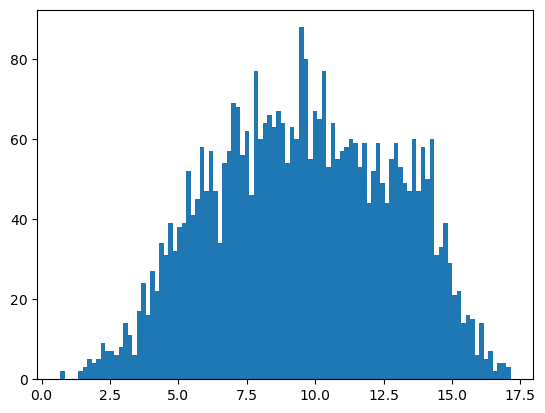

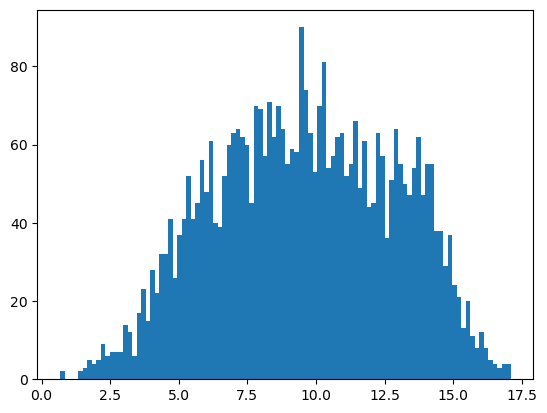

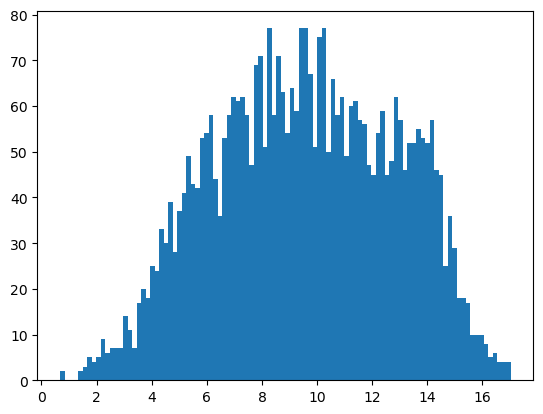

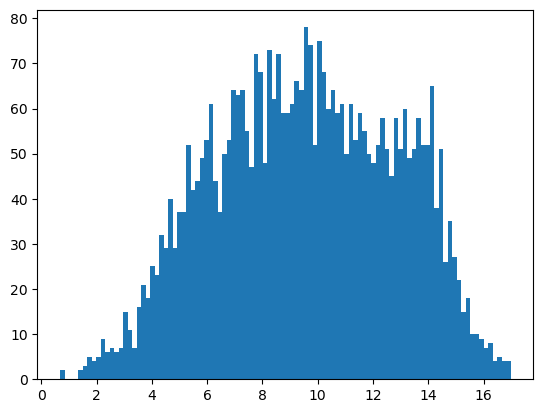

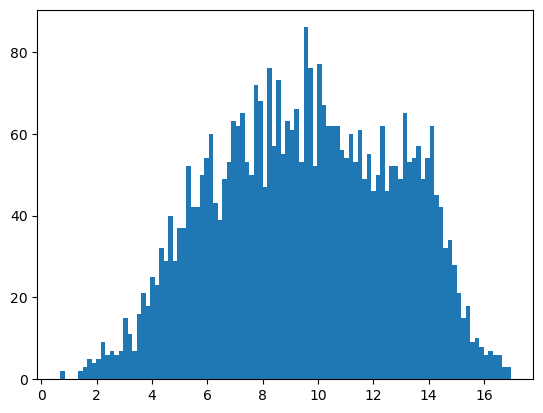

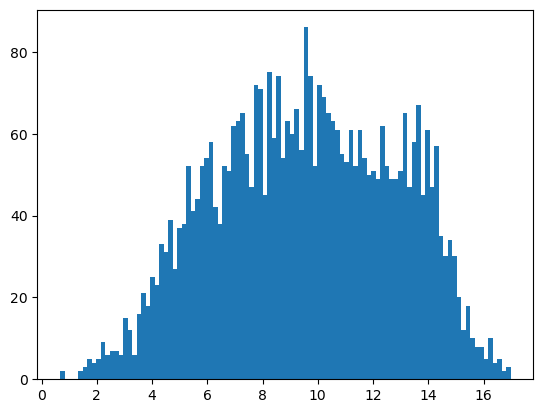

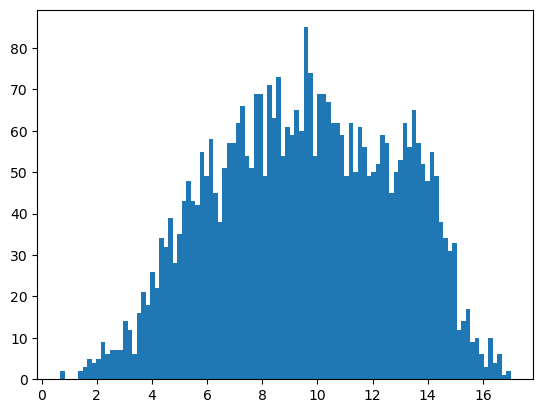

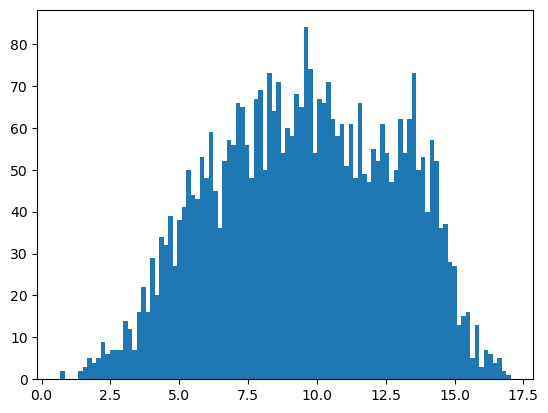

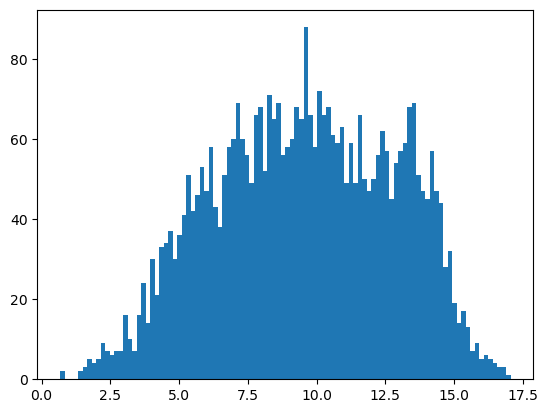

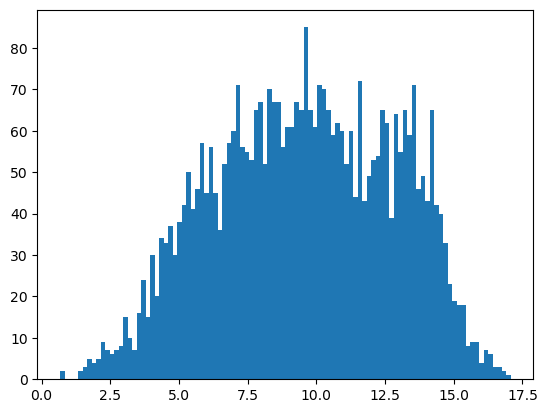

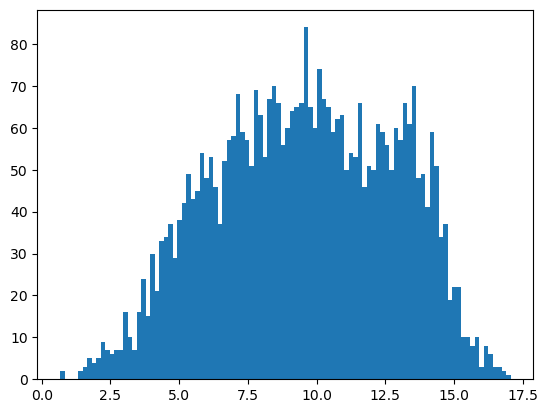

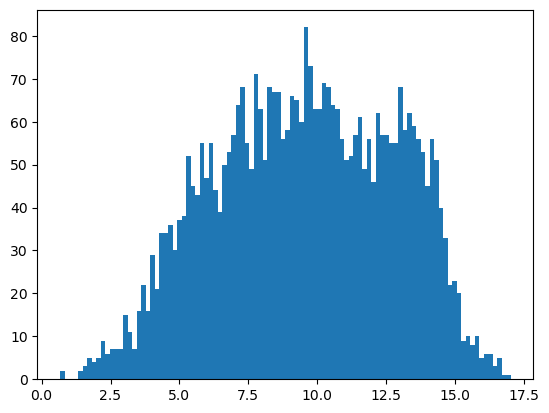

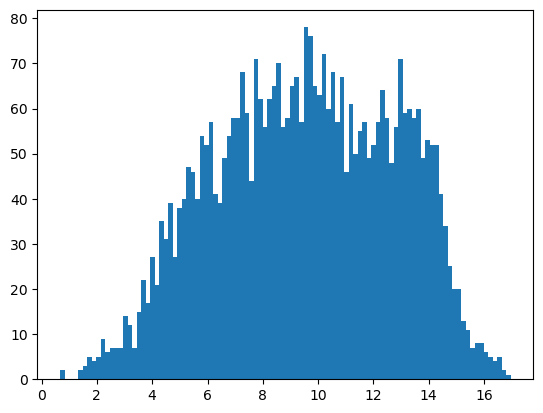

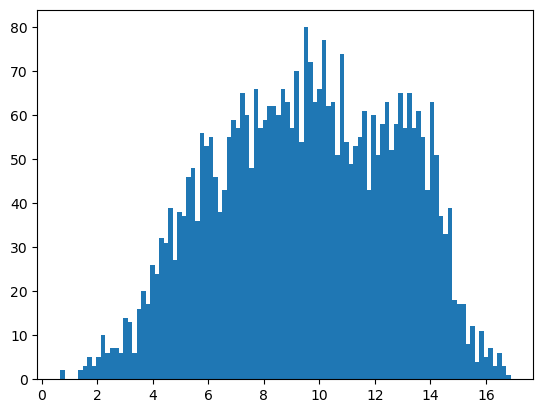

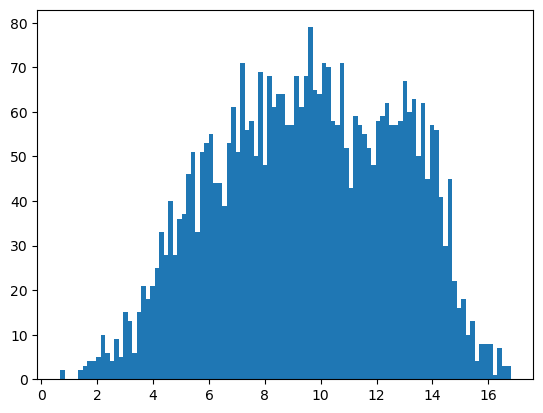

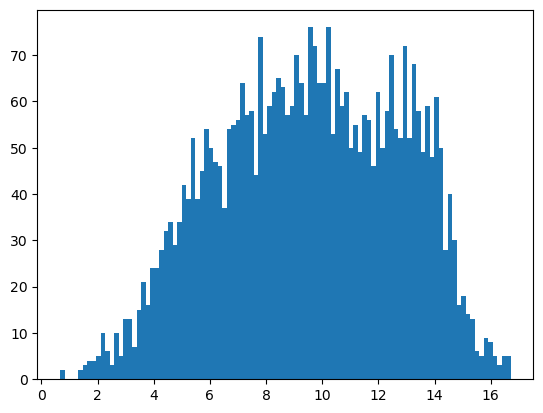

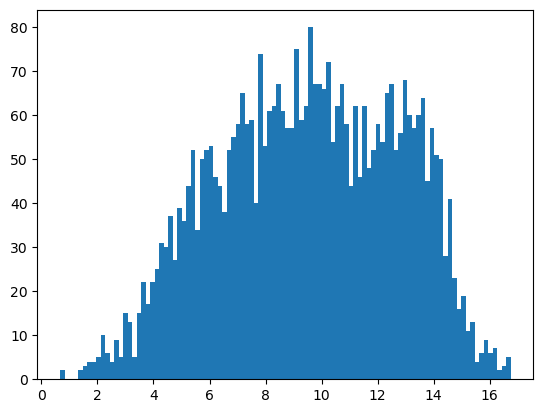

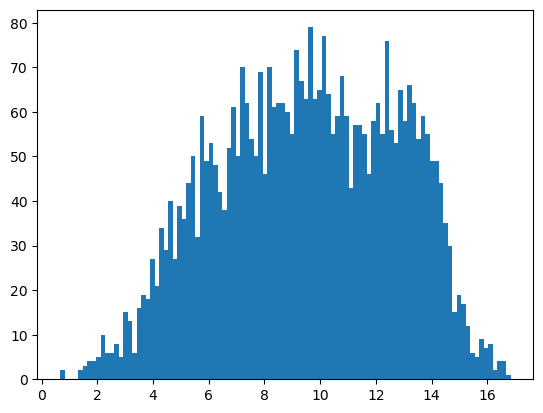

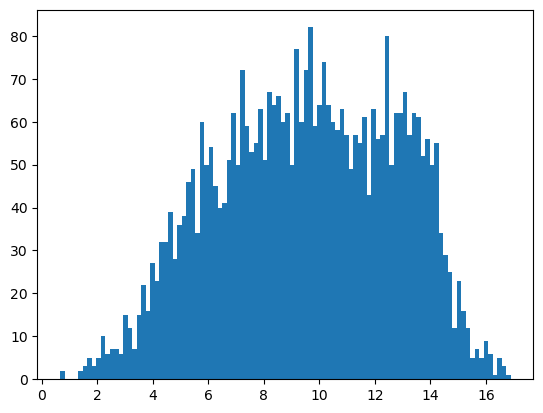

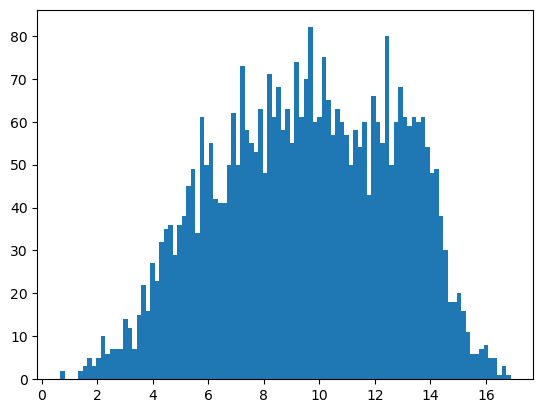

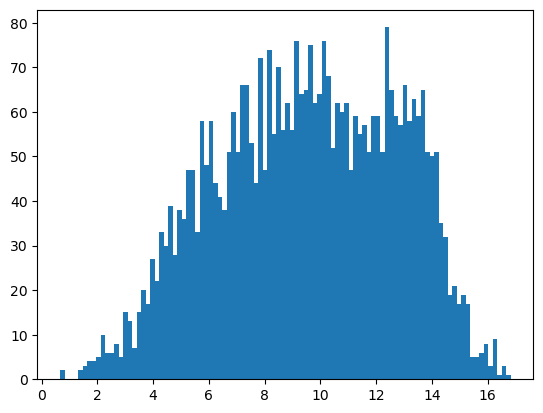

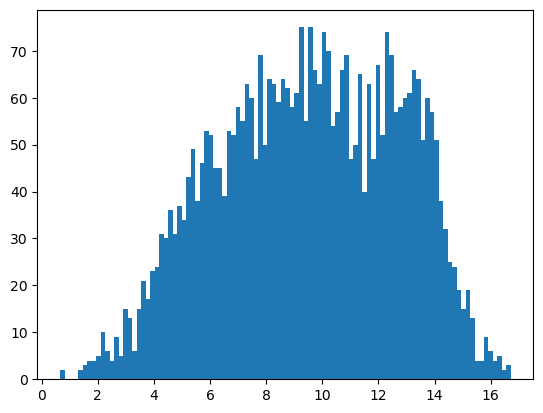

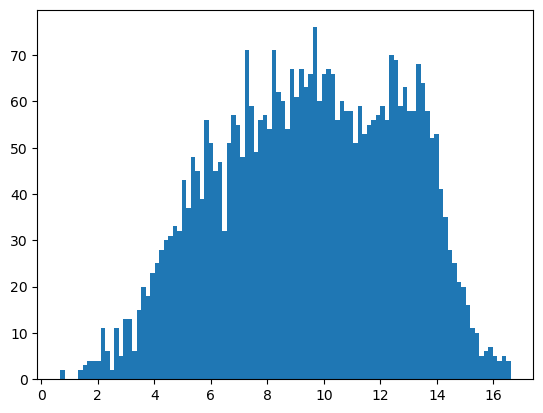

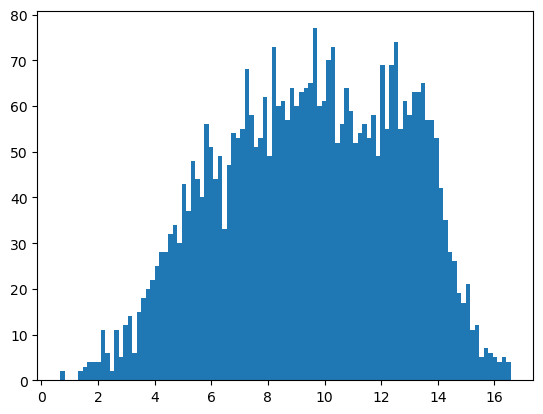

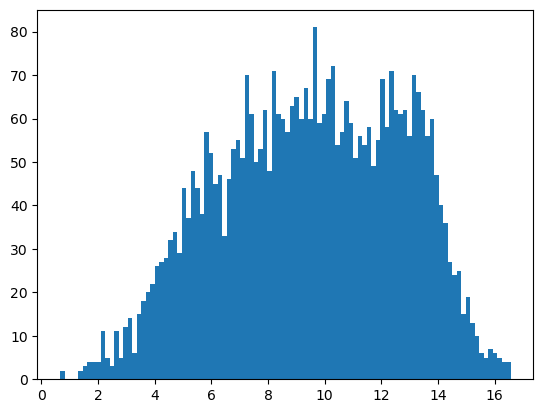

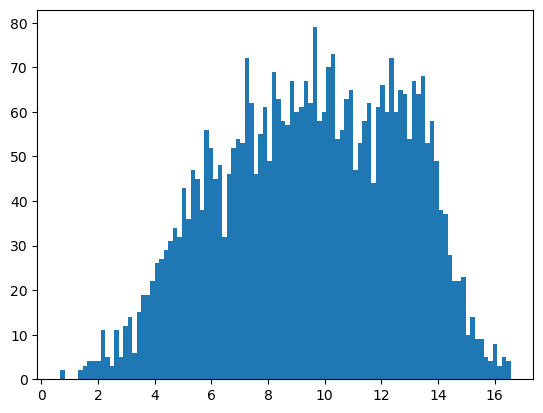

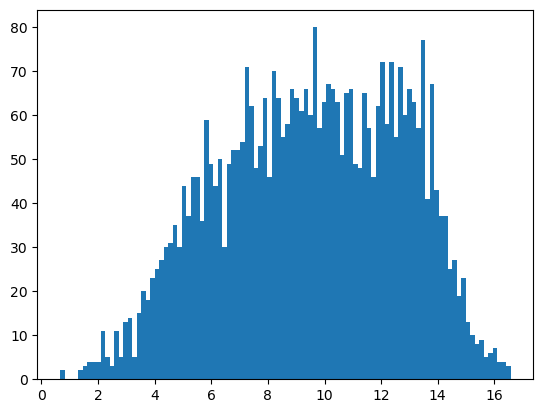

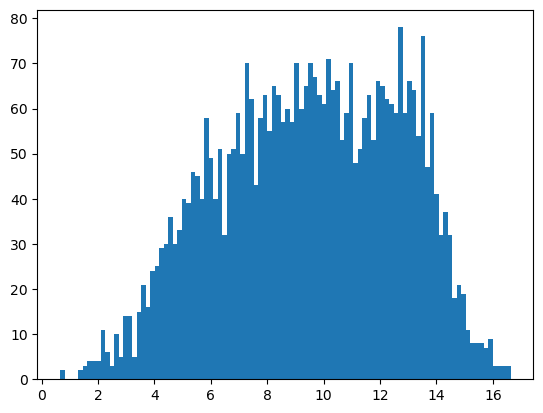

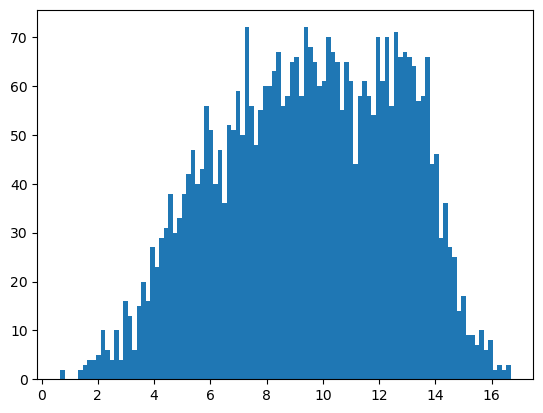

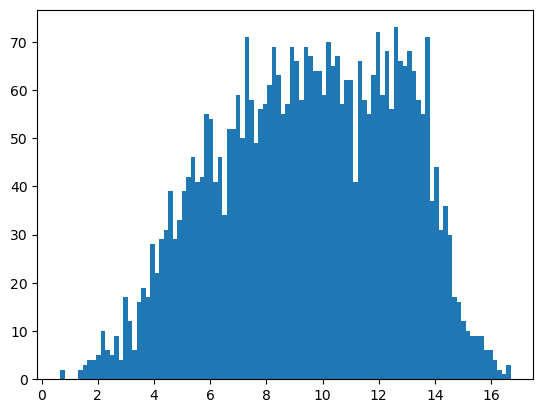

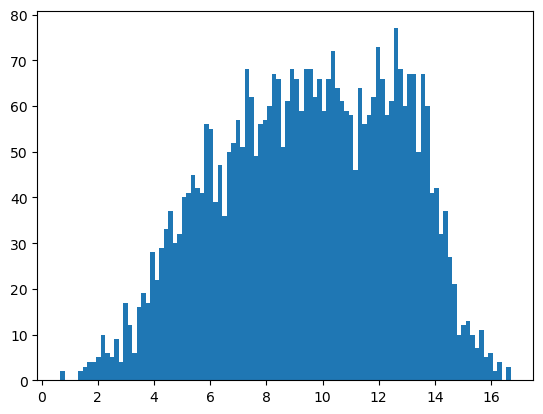

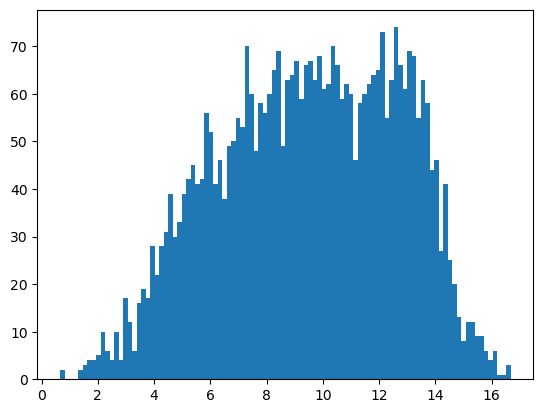

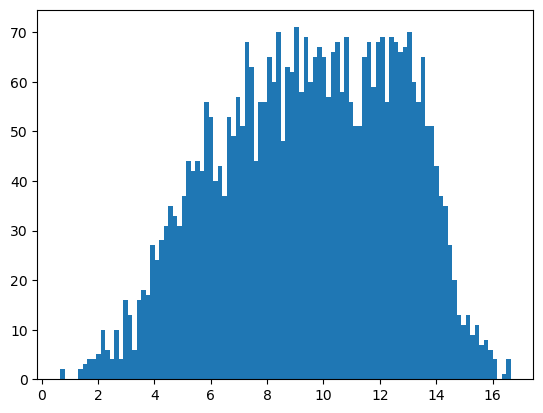

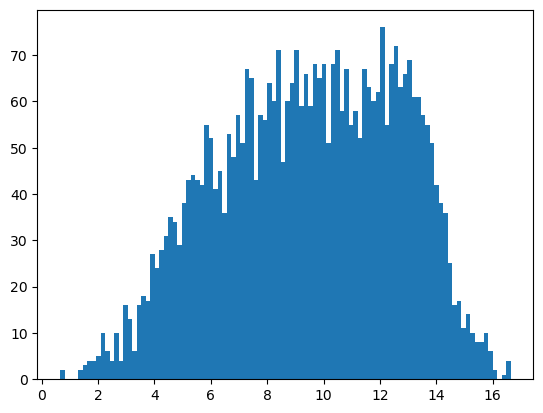

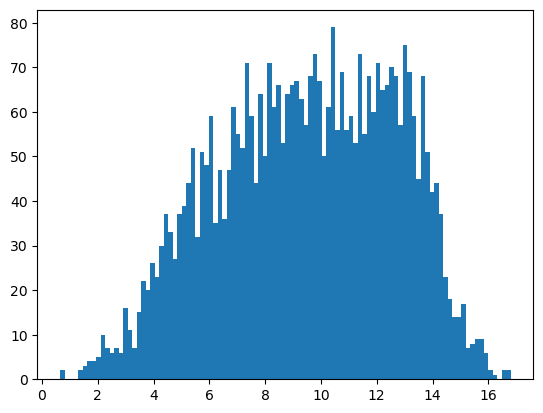

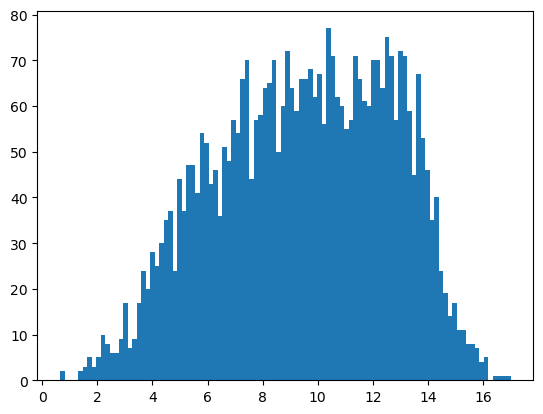

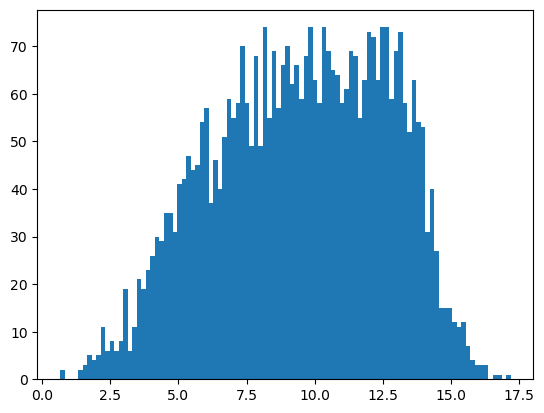

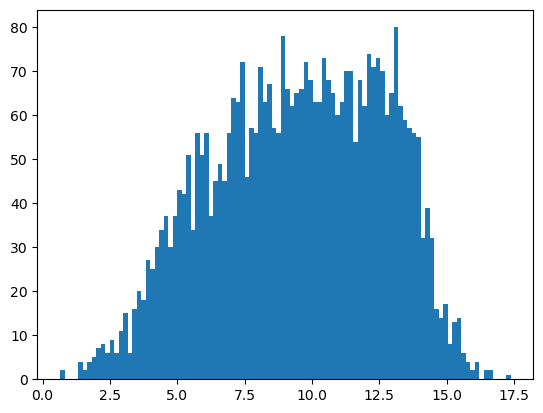

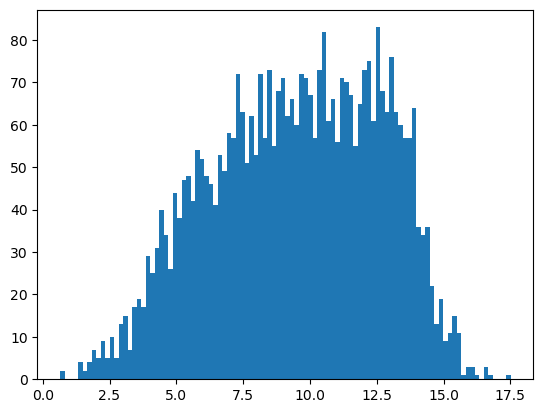

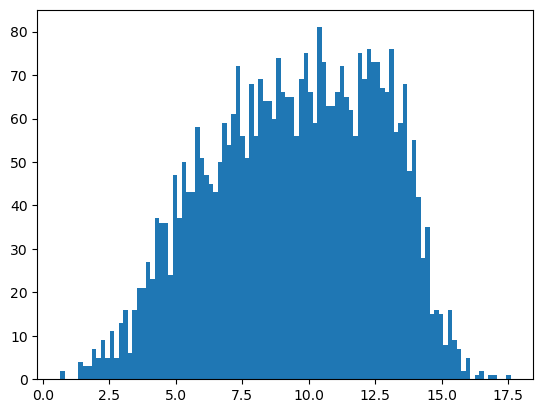

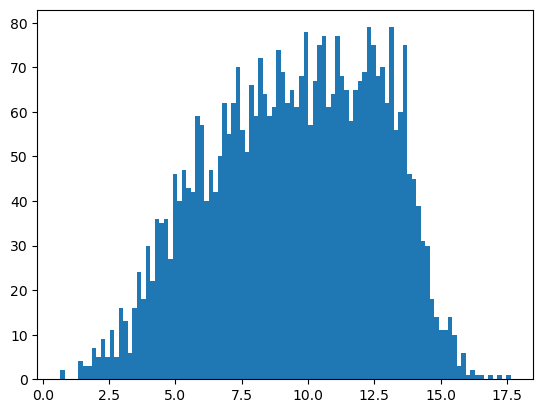

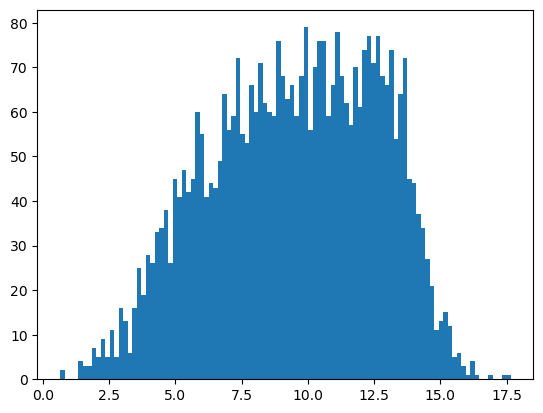

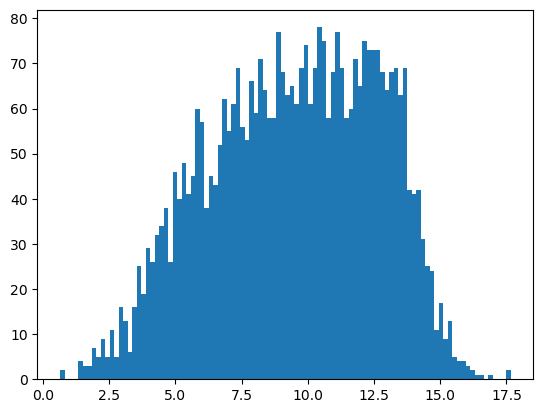

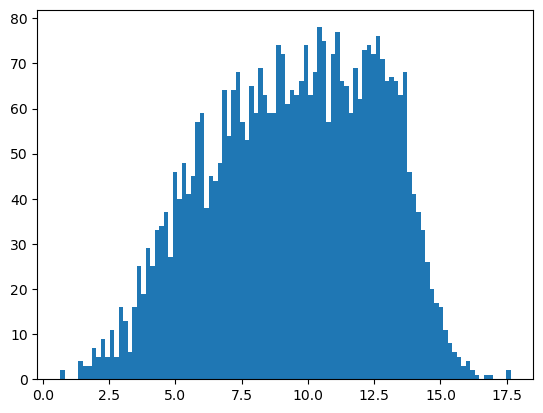

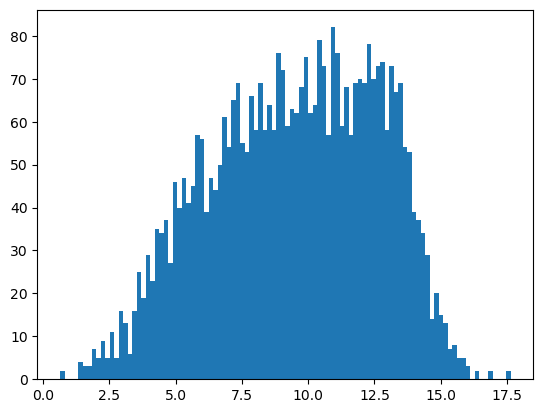

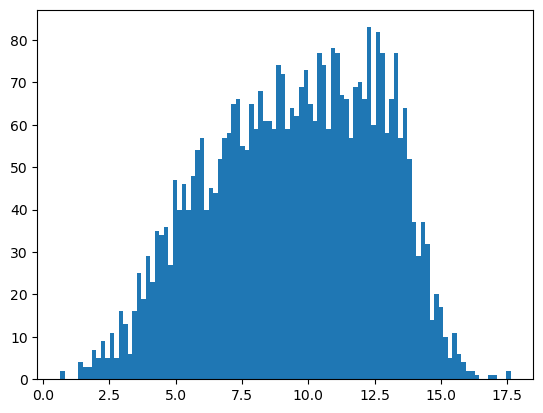

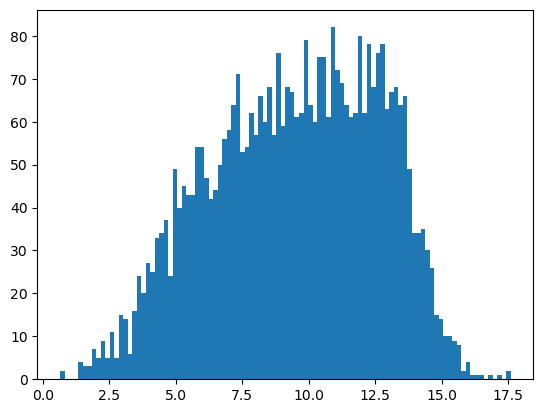

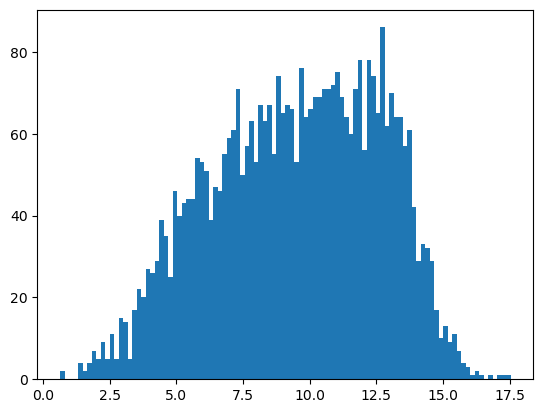

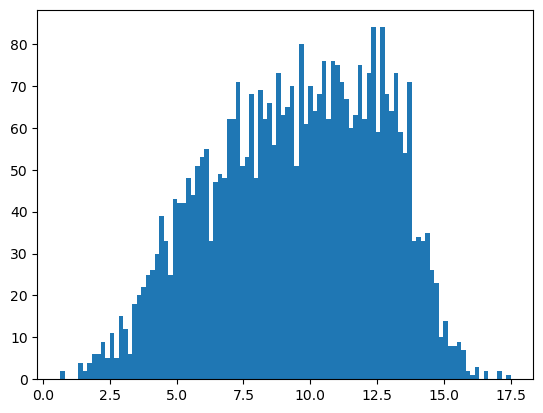

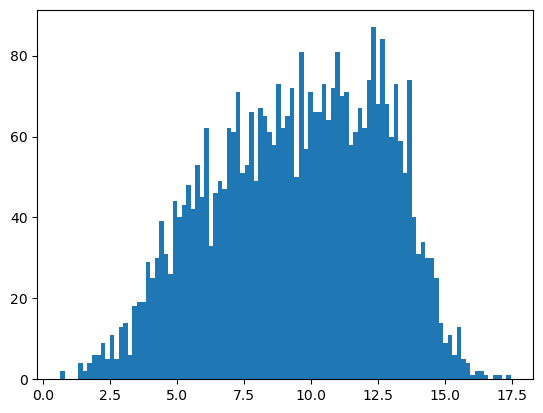

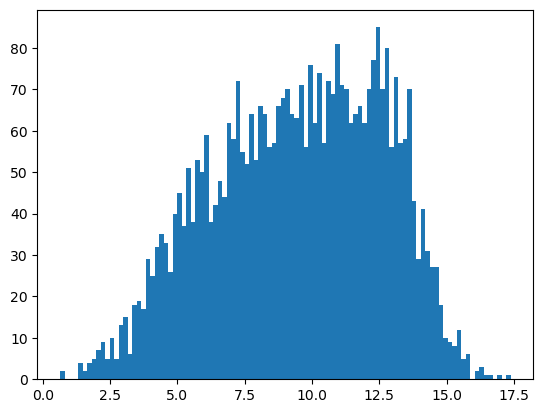

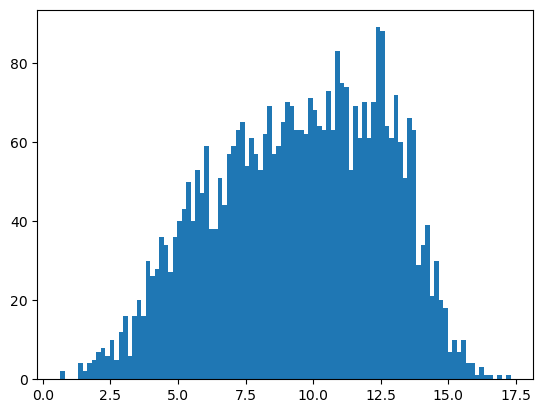

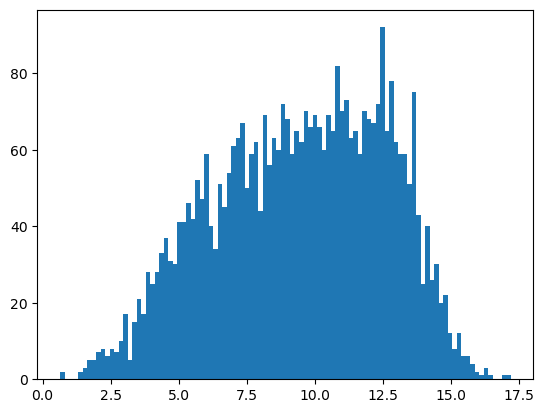

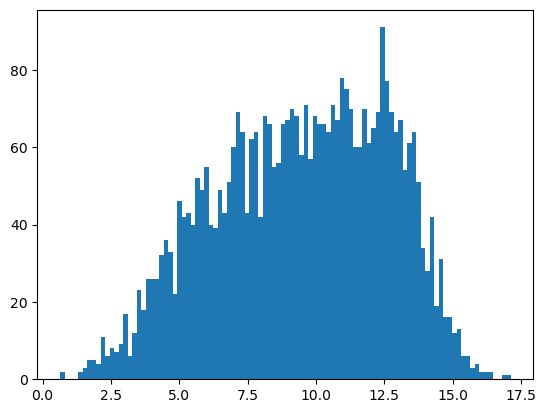

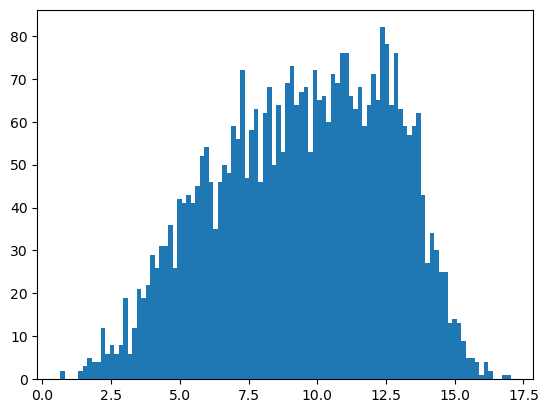

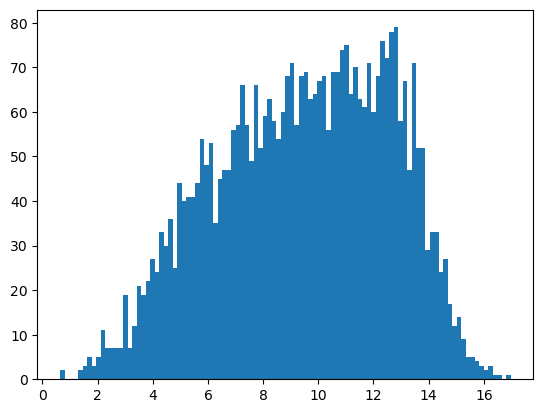

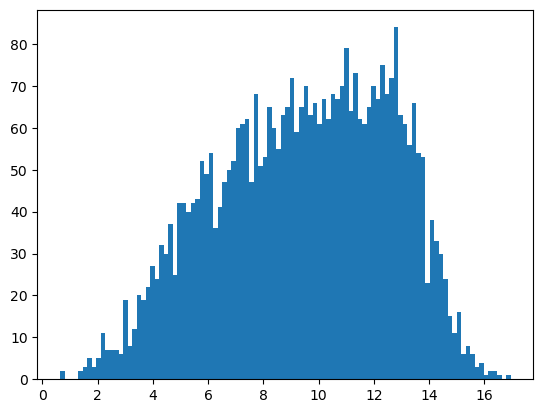

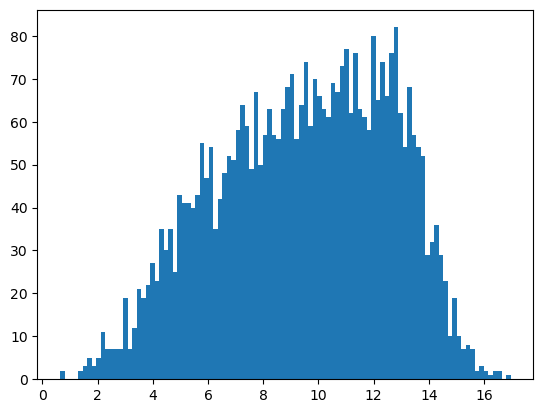

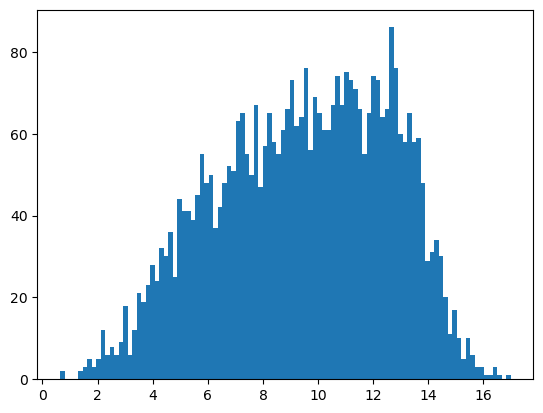

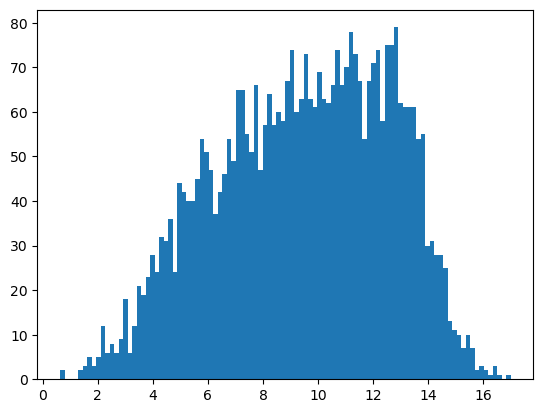

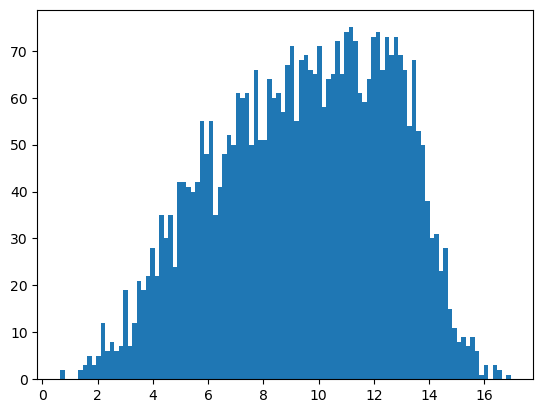

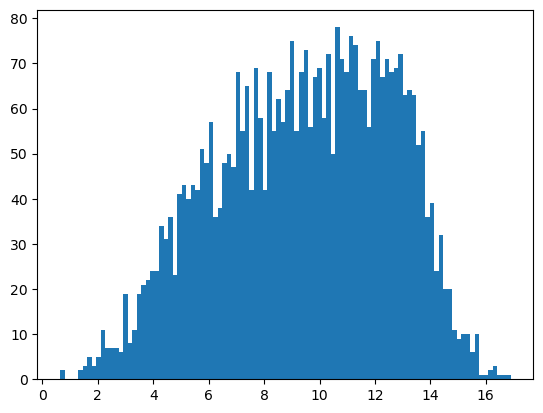

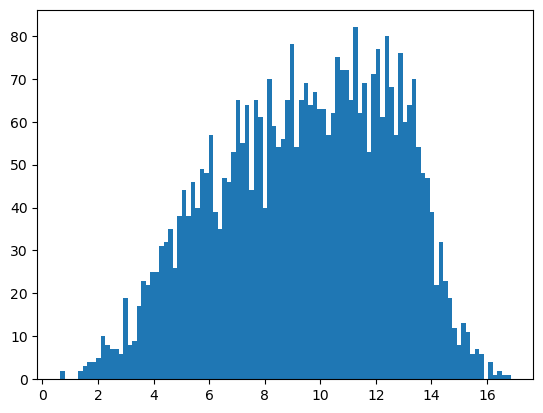

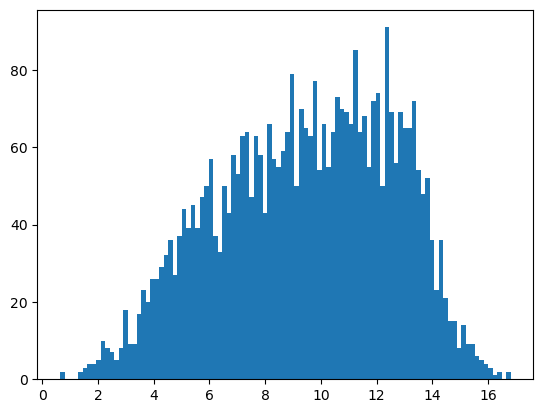

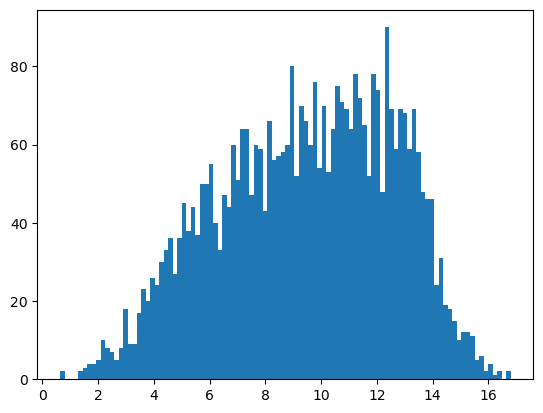

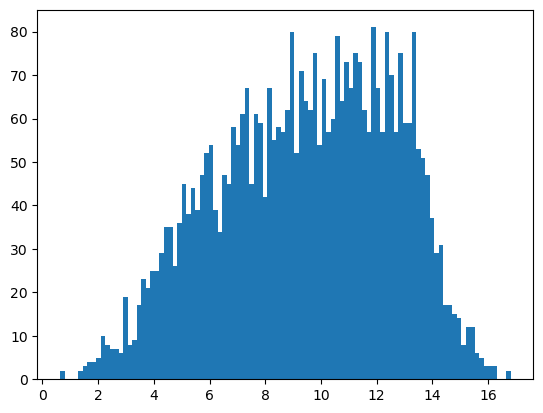

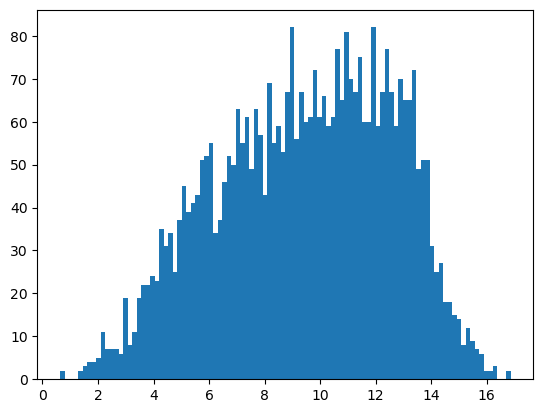

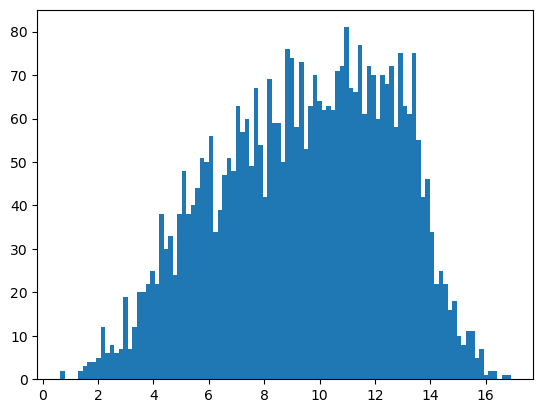

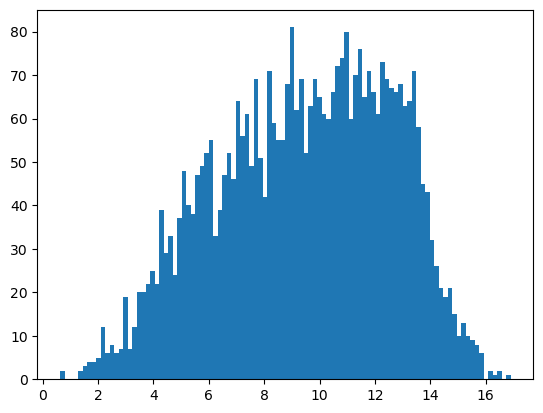

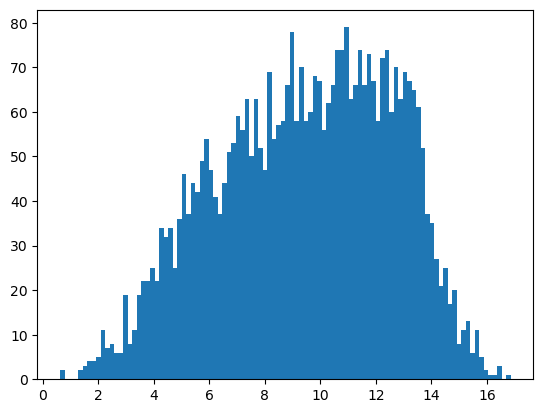

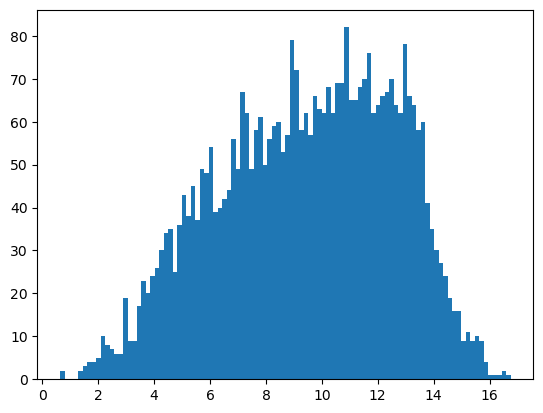

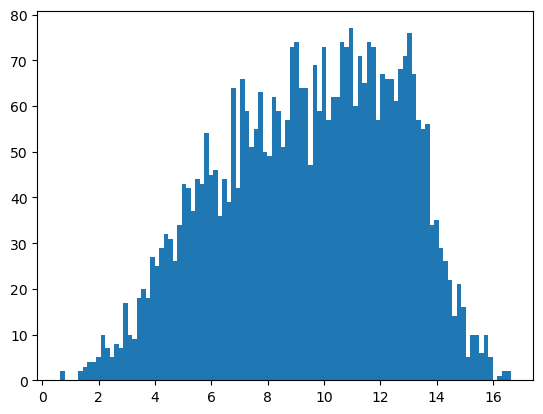

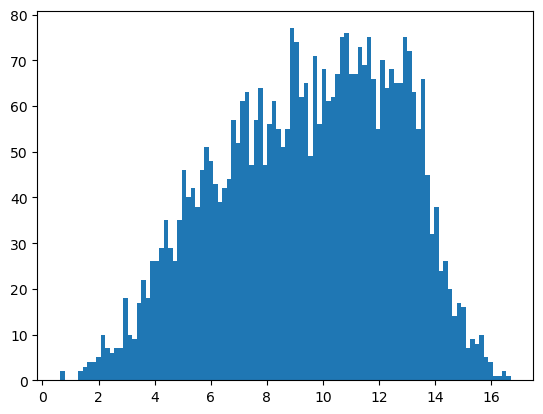

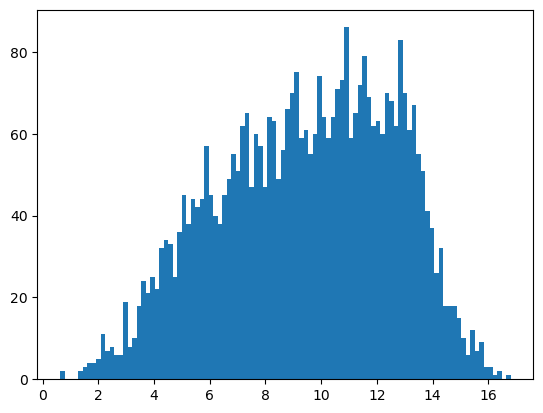

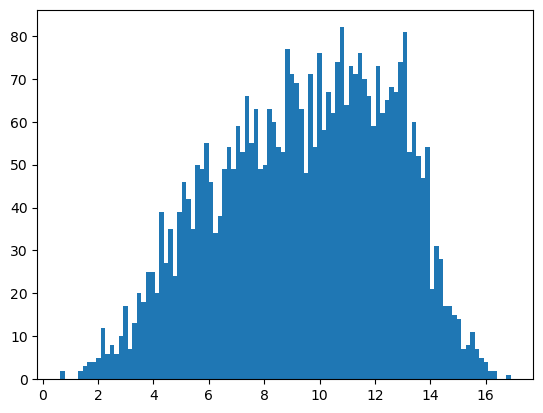

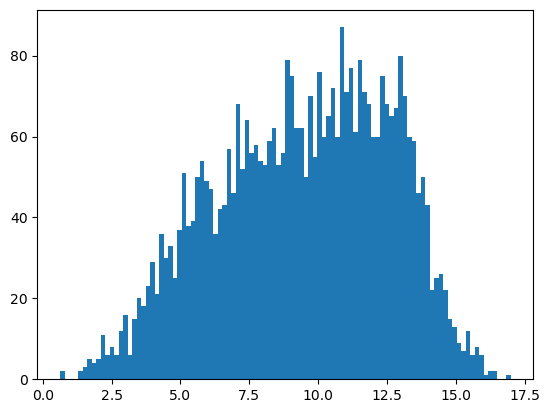

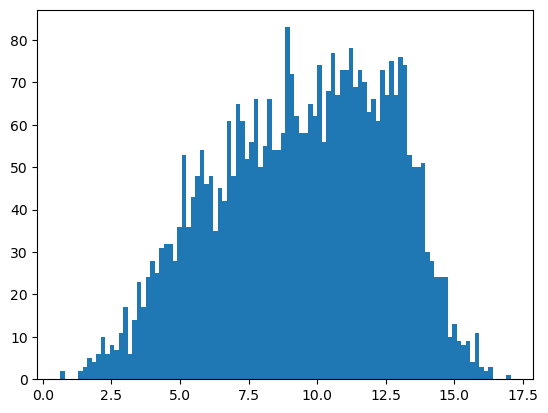

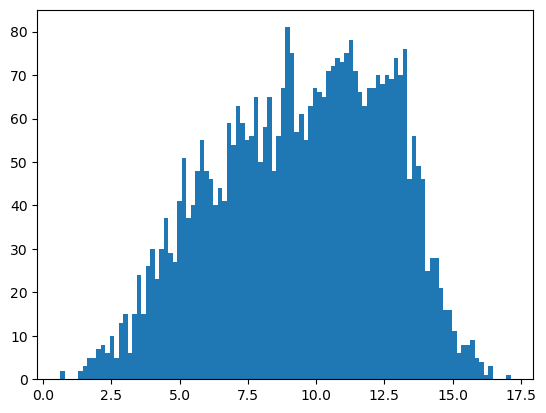

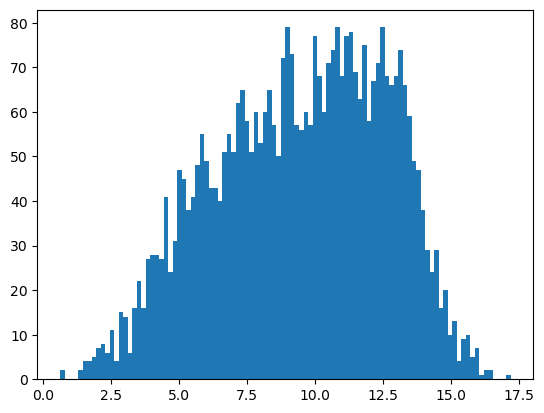

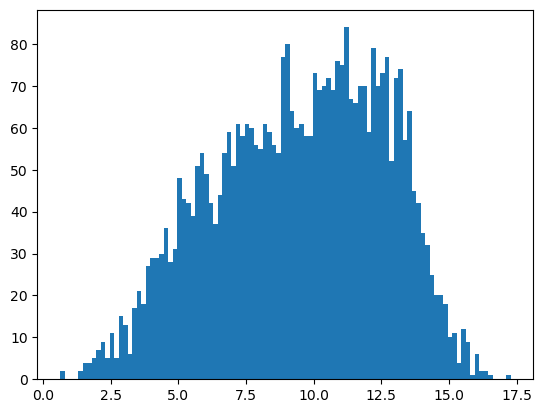

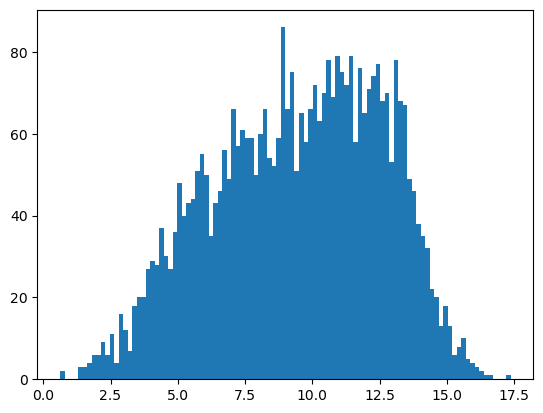

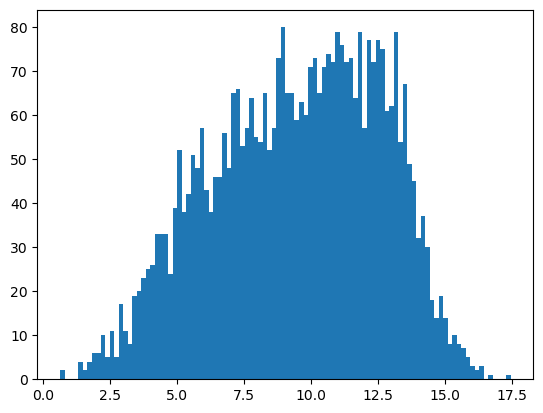

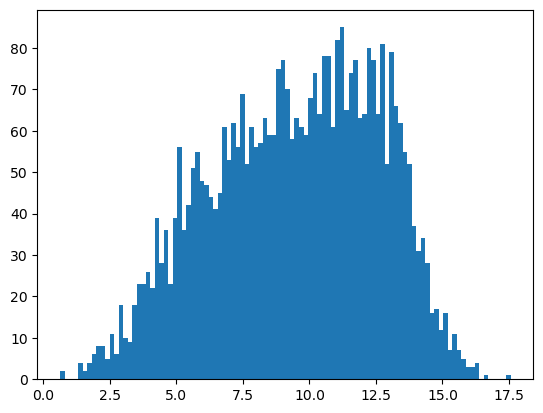

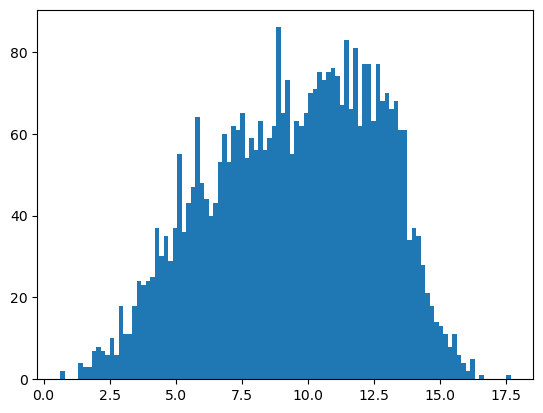

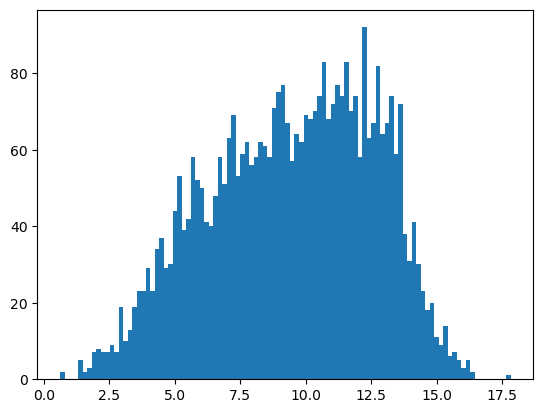

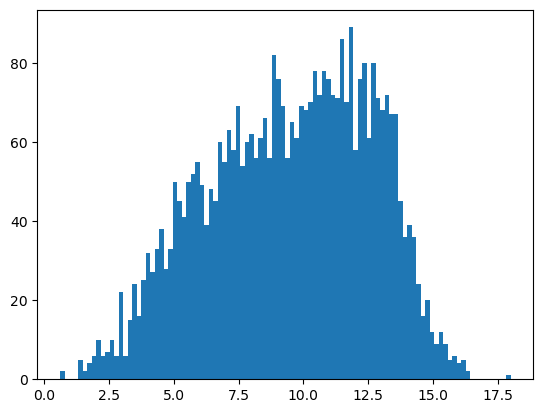

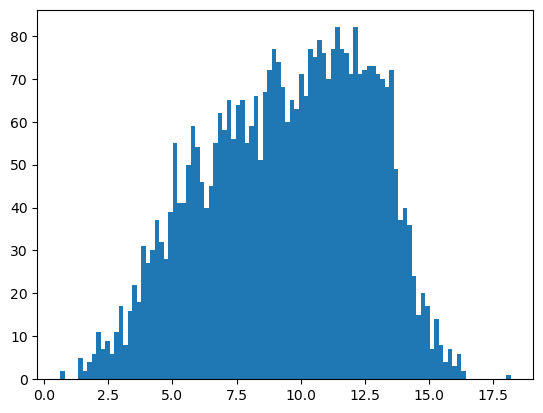

In [5]:
from generate_data import evolve
from utils import split_model, torch_expand

for model in ensemble:
    model.eval()

X = Y[256:, 0:1]
# with torch.no_grad():

#     preds = [torch_expand(X[:,None], 1, len(ensemble))] # [datasize, ensemble_size, 1, nx]
#     for t in range(nt-1):
#         X_t = preds[-1].clone()
#         X_t = torch.stack([split_model(model, cfg.eval_batch_size)(X_t[:, i].to(device)).cpu() for i, model in enumerate(ensemble)], dim=1) # [datasize, ensemble_size, 1, nx] 
#         preds.append(X_t)
#     mean = torch.cat(preds, dim=2).mean(dim=1) # [datasize, nt, nx]
#     # variance = torch.cat(preds, dim=2).var(dim=1) # [datasize, nt, nx]
#     # variance_per_data = variance.mean(dim=(1,2)) # [datasize]
#     # norm_per_data = torch.norm(mean, dim=(1,2)) # [datasize]
#     # rel = variance_per_data / norm_per_data # [datasize]
#     # ready = rel < 0.2 # [datasize]
#     ready = torch.max(mean, dim=2).values.max(dim=1).values.abs() < 4
#     print(f'Ready: {ready.sum().item()} out of {X.shape[0]}')

ready = torch.ones(X.shape[0]).bool()

model = ensemble[0]
with torch.no_grad():
    X_t = X[ready]
    X_t = X_t.to(device)
    norms=X_t.norm(dim=tuple(range(2, X_t.dim())))
    plt.figure()
    plt.hist(norms.cpu().numpy(), bins=100)
    # print(x.max())
    traj = [X_t]
    for t in range(nt-1):
        # if t%15 == 0:
        if False:
            x = evolve(x, cfg).to(device)
        else:
            prev_norm = X_t.norm(dim=tuple(range(2, X_t.dim())), keepdim=True)
            X_t = split_model(model, 256)(X_t)
            # x = x / x.norm(dim=tuple(range(2, x.dim())), keepdim=True) * prev_norm
        norms=X_t.norm(dim=tuple(range(2, X_t.dim())))
        plt.figure()
        plt.hist(norms.cpu().numpy(), bins=100)
        # print(x.max())
        traj.append(X_t)
    
traj_single = torch.cat(traj, dim=1)


In [6]:
from generate_data import evolve
from utils import split_model, torch_expand

for model in ensemble:
    model.eval()

X = Y[256:, 0:1]
# with torch.no_grad():

#     preds = [torch_expand(X[:,None], 1, len(ensemble))] # [datasize, ensemble_size, 1, nx]
#     for t in range(nt-1):
#         X_t = preds[-1].clone()
#         X_t = torch.stack([split_model(model, cfg.eval_batch_size)(X_t[:, i].to(device)).cpu() for i, model in enumerate(ensemble)], dim=1) # [datasize, ensemble_size, 1, nx] 
#         preds.append(X_t)
#     mean = torch.cat(preds, dim=2).mean(dim=1) # [datasize, nt, nx]
#     # variance = torch.cat(preds, dim=2).var(dim=1) # [datasize, nt, nx]
#     # variance_per_data = variance.mean(dim=(1,2)) # [datasize]
#     # norm_per_data = torch.norm(mean, dim=(1,2)) # [datasize]
#     # rel = variance_per_data / norm_per_data # [datasize]
#     # ready = rel < 0.2 # [datasize]
#     ready = torch.max(mean, dim=2).values.max(dim=1).values.abs() < 4
#     print(f'Ready: {ready.sum().item()} out of {X.shape[0]}')

ready = torch.ones(X.shape[0]).bool()

traj_ensemble = []
for i in range(ensemble_size):
    with torch.no_grad():
        model = ensemble[i]
        X_t = X[ready]
        X_t = X_t.to(device)
        norms=X_t.norm(dim=tuple(range(2, X_t.dim())))
        # print(x.max())
        traj = [X_t]
        for t in range(nt-1):
            # if t%15 == 0:
            if False:
                x = evolve(x, cfg).to(device)
            else:
                prev_norm = X_t.norm(dim=tuple(range(2, X_t.dim())), keepdim=True)
                X_t = split_model(model, 256)(X_t)
                # x = x / x.norm(dim=tuple(range(2, x.dim())), keepdim=True) * prev_norm
            norms=X_t.norm(dim=tuple(range(2, X_t.dim())))
            # print(x.max())
            traj.append(X_t)
    traj_ensemble.append(torch.cat(traj, dim=1))
traj_ensemble = torch.stack(traj_ensemble, dim=0).mean(dim=0)



OutOfMemoryError: CUDA out of memory. Tried to allocate 2.40 GiB. GPU 0 has a total capacity of 10.75 GiB of which 1.52 GiB is free. Process 1261340 has 1.77 GiB memory in use. Process 1238099 has 4.62 GiB memory in use. Process 1437028 has 1.49 GiB memory in use. Process 1454896 has 1.36 GiB memory in use. Of the allocated memory 3.44 GiB is allocated by PyTorch, and 48.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
real_traj = Y[256:][ready, :traj.shape[1]]
print(traj.shape, real_traj.shape)
assert real_traj.shape == traj.shape

print('Computing metrics...')
metrics = compute_metrics(real_traj.flatten(1), traj.flatten(1))
print(metrics[0].mean())
print(metrics[1].mean())
print(metrics[2].mean())

torch.Size([3485, 14, 256]) torch.Size([3485, 14, 256])
Computing metrics...
tensor(0.2948, device='cuda:0')
tensor(0.4594, device='cuda:0')
tensor(513.9716, device='cuda:0')


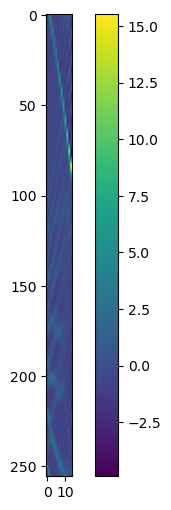

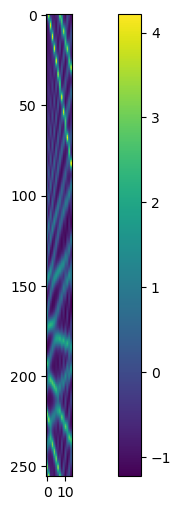

In [ ]:
idx = 2252
plt.figure()
plt.imshow(traj[idx].cpu().numpy().T)
plt.colorbar()


plt.figure()
plt.imshow(real_traj[idx].cpu().numpy().T)
plt.colorbar()